#### Setup

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import scvi
import scrnatools as rna
import seaborn as sns
import pandas as pd
from adjustText import adjust_text
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
import numpy as np
import pickle
import logging
import scipy
from scipy.stats import spearmanr, pearsonr
import scanpy as sc

In [3]:
# Set seeds
scvi.settings.seed = 0
scvi.settings.verbosity = logging.WARNING

Global seed set to 0


In [4]:
# Setup figure params
plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Helvetica"
sc.set_figure_params(dpi=80, dpi_save=300, facecolor="white", frameon=False)
sns.set_context("paper")
plt.rcParams["axes.grid"] = False
plt.rcParams['axes.unicode_minus'] = False
cmap = sns.color_palette("colorblind")

In [5]:
warnings.resetwarnings()

# Import data

Data paths

In [6]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

In [7]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

In [8]:
aire = sc.read(f"{processedDataPath}/Fezf2_thymus_paper/h5ad_files/pairwise_processing/aire_TECs.h5ad")
fezf2 = sc.read(f"{processedDataPath}/Fezf2_thymus_paper/h5ad_files/pairwise_processing/fezf2_TECs.h5ad")
aire_model = scvi.model.SCVI.load(
    f"{processedDataPath}/Fezf2_thymus_paper/scVI_models/pairwise_processing/aire",
    adata=aire,
)
fezf2_model = scvi.model.SCVI.load(
    f"{processedDataPath}/Fezf2_thymus_paper/scVI_models/pairwise_processing/fezf2",
    adata=fezf2,
)

In [9]:
adatas = {"Aire": aire, "Fezf2": fezf2}
models = {"Aire": aire_model, "Fezf2": fezf2_model}

# scVI DE

In [10]:
def scvi_cell_type_de(
    adata, 
    model,
    cell_type_key, 
    group_key, condition_group, control_group, 
    min_cells
):
    all_genes = pd.DataFrame()

    for cell_type in adata.obs[cell_type_key].unique():
        subset_data = adata[adata.obs[cell_type_key] == cell_type].copy()
        num_control = sum([i == control_group for i in subset_data.obs[group_key]])
        num_condition = sum([i == condition_group for i in subset_data.obs[group_key]])
        if num_control > min_cells and num_condition > min_cells:
            print(cell_type)
            de_genes = model.differential_expression(
                adata=subset_data,
                groupby=group_key,
                group1=condition_group,
                group2=control_group,
                silent=True,
            )
            de_genes["cell_type"] = cell_type
            all_genes = pd.concat([all_genes, de_genes])
        else:
            print(f"{cell_type} had too few cells in at least one group, skipping")

    all_genes["gene"] = all_genes.index
    all_genes.index = all_genes.index + "_" + all_genes.cell_type
    all_genes = all_genes.sort_index()
    all_genes["abs_lfc"] = abs(all_genes.lfc_mean)
    
    return all_genes

def filter_scvi_de_genes(
    adata, 
    df, 
    bayes_thresh, lfc_thresh, nonzero_thresh, 
    percentile, cell_type_key, expression_layer, peak_expression_thresh, 
    save_path=None,
    ylim=None, *args, **kwargs
):
    for cell_type in df.cell_type.unique():
        expression = rna.tl.get_expression_matrix(
            adata[adata.obs[cell_type_key] == cell_type],
            expression_layer
        )
        percentile_expression = pd.DataFrame(
            np.quantile(expression, percentile, axis=0),
            index=[f"{i}_{cell_type}" for i in expression.columns]
        )
        df.loc[percentile_expression.index, f"expression_{percentile}"] = percentile_expression[0]
    detected_genes = df[df[f"expression_{percentile}"] > peak_expression_thresh].copy()
    detected_genes = detected_genes[
        (detected_genes.non_zeros_proportion1 > nonzero_thresh) |
        (detected_genes.non_zeros_proportion2 > nonzero_thresh)
    ]
    
    ax = plt.scatter(
        x=detected_genes.lfc_mean,
        y=detected_genes.bayes_factor,
        s=1,
        rasterized=True,
        *args, **kwargs
    )
    plt.xlabel("lfc_mean")
    plt.ylabel("bayes_factor")
    plt.axhline(y=bayes_thresh, c="black")
    plt.axvline(x=lfc_thresh, c="black")
    plt.axvline(x=-1*lfc_thresh, c="black")
    if ylim is not None:
        plt.ylim(ylim)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(f"{save_path}", dpi=300)
    plt.show()
    
    filtered_genes = detected_genes[detected_genes.bayes_factor > bayes_thresh].copy()
    filtered_genes = filtered_genes[abs(filtered_genes.lfc_mean) > lfc_thresh]
    
    return detected_genes, filtered_genes

## Run DE

In [11]:
all_genes = {}
for genotype in ["Aire", "Fezf2"]:
    adata = adatas[genotype]
    model = models[genotype]
    for sample in adata.obs["sample"].unique():
        subset_data = adata[adata.obs["sample"] == sample]
        data = subset_data[subset_data.obs.batch.str.contains(genotype)]
        print(f"{genotype}-{sample}")
        all_gene = scvi_cell_type_de(
            adata=data,
            model=model,
            cell_type_key="majority_voting",
            group_key="genotype",
            condition_group=f"{genotype}_KO",
            control_group="WT",
            min_cells=30,
        )
        all_genes[f"{genotype}-{sample}"] = all_gene
        print()

Aire-1
Aire-stage
Tuft2
Gut/Liver
Immature MEC
Ciliated had too few cells in at least one group, skipping
Tuft1
Skin, keratinized had too few cells in at least one group, skipping
Skin, basal
Lung, basal
Goblet had too few cells in at least one group, skipping
TA MEC
Neuroendocrine
Mcell

Aire-2
Immature MEC
Aire-stage
TA MEC
Ciliated had too few cells in at least one group, skipping
Neuroendocrine
Skin, basal
Gut/Liver
Lung, basal
Tuft2
Goblet
Mcell
Tuft1
Skin, keratinized had too few cells in at least one group, skipping

Fezf2-1
Gut/Liver
Tuft2
Immature MEC
Aire-stage
adult cTEC
Neuroendocrine
Skin, keratinized
Goblet
Skin, basal
Tuft1 had too few cells in at least one group, skipping
Mcell
TA MEC
Ciliated
Lung, basal
Ionocyte had too few cells in at least one group, skipping

Fezf2-2
TA MEC
Aire-stage
Neuroendocrine had too few cells in at least one group, skipping
Immature MEC
Tuft2
Skin, keratinized
Gut/Liver
Mcell
Goblet
Skin, basal
Tuft1 had too few cells in at least one group,

## Filter

Aire-1


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


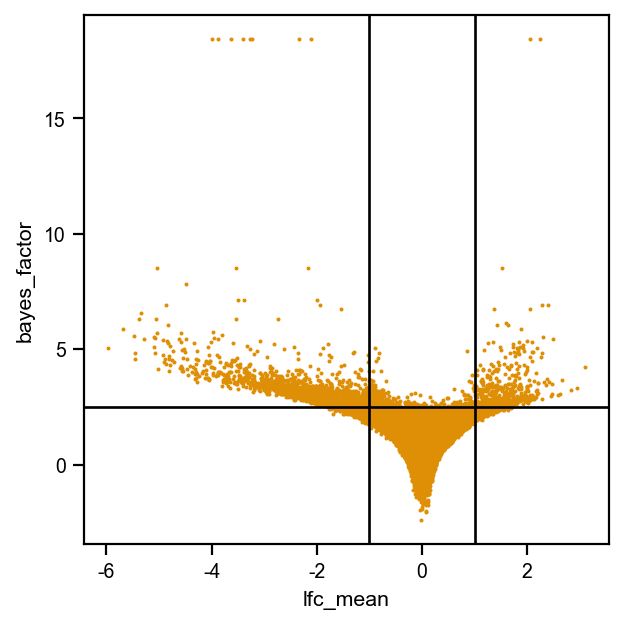

Aire-2


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


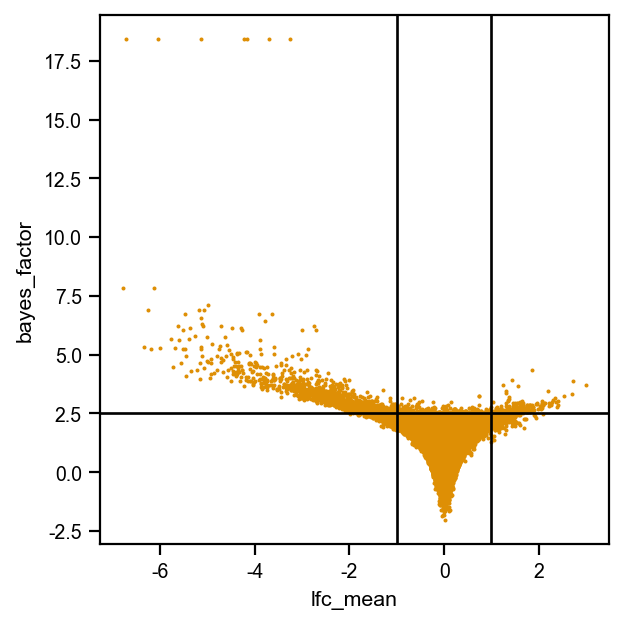

Fezf2-1


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


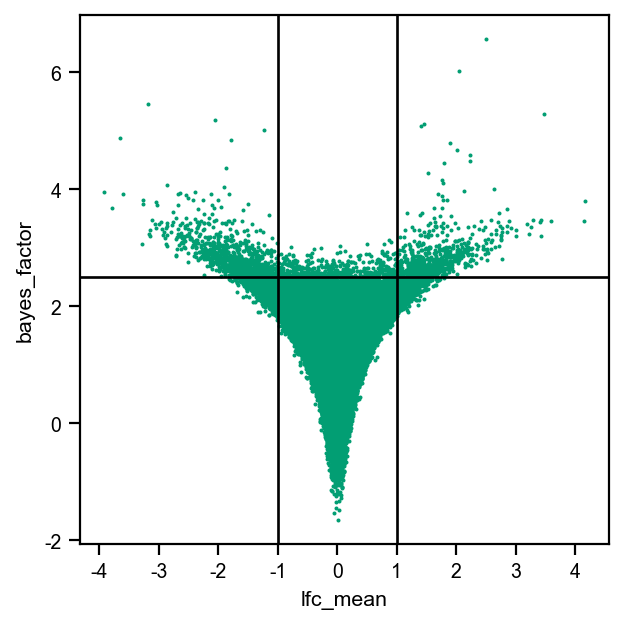

Fezf2-2


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


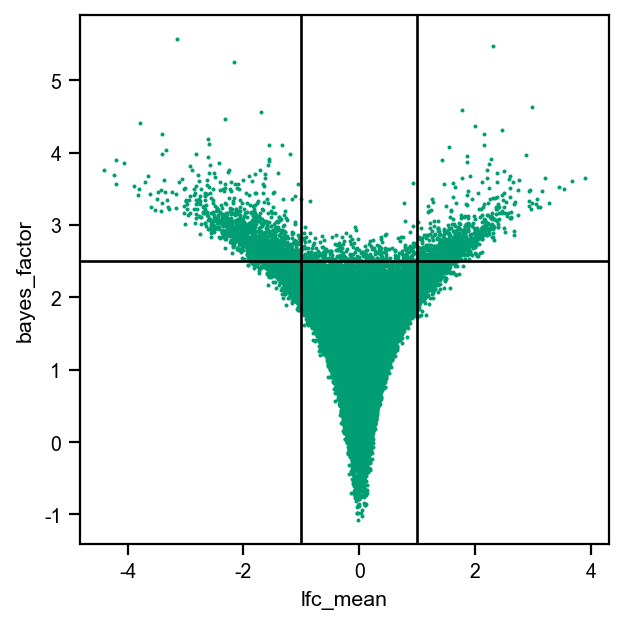

In [12]:
detected_genes = {}
filtered_genes = {}
for key, all_gene in all_genes.items():
    print(key)
    genotype, sample = key.split("-")
    if genotype == "Aire":
        color=cmap[1]
    else:
        color=cmap[2]
    adata = adatas[genotype]
    subset_data = adata[adata.obs.batch.str.contains(genotype) & (adata.obs["sample"] == sample)]
    detected_gene, filtered_gene = filter_scvi_de_genes(
        adata=subset_data,
        cell_type_key="majority_voting",
        expression_layer="scVI_normalized",
        df=all_gene,
        bayes_thresh=2.5,
        lfc_thresh=1,
        nonzero_thresh=0.05,
        percentile=0.99,
        peak_expression_thresh=0.5,
        c=color,
    )
    detected_genes[key] = detected_gene
    filtered_genes[key] = filtered_gene

## WT DE

In [13]:
all_genes_WT = {}
for genotype in ["Aire", "Fezf2"]:
    adata = adatas[genotype]
    model = models[genotype]
    data = adata[adata.obs.batch.str.contains(f"{genotype}_WT")]
    print(f"{genotype}")
    all_gene = scvi_cell_type_de(
        adata=data,
        model=model,
        cell_type_key="majority_voting",
        group_key="sample",
        condition_group="1",
        control_group="2",
        min_cells=30,
    )
    all_genes_WT[genotype] = all_gene
    print()

Aire
Aire-stage
Tuft2
Gut/Liver
Immature MEC
Ciliated
Tuft1
Skin, keratinized had too few cells in at least one group, skipping
Skin, basal
Lung, basal
Goblet had too few cells in at least one group, skipping
TA MEC
Neuroendocrine
Mcell

Fezf2
Gut/Liver
Tuft2
Immature MEC
Aire-stage
adult cTEC had too few cells in at least one group, skipping
Neuroendocrine
Skin, keratinized
Goblet
Skin, basal
Tuft1
Mcell
TA MEC
Ciliated
Lung, basal
Ionocyte had too few cells in at least one group, skipping



Aire


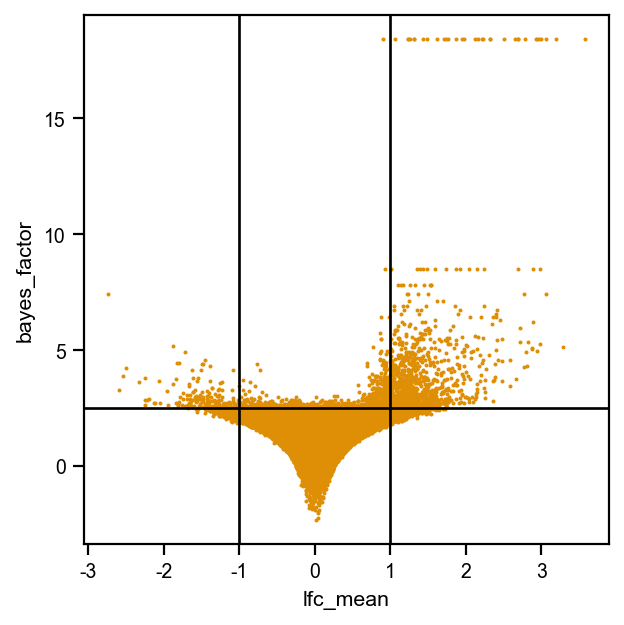

Fezf2


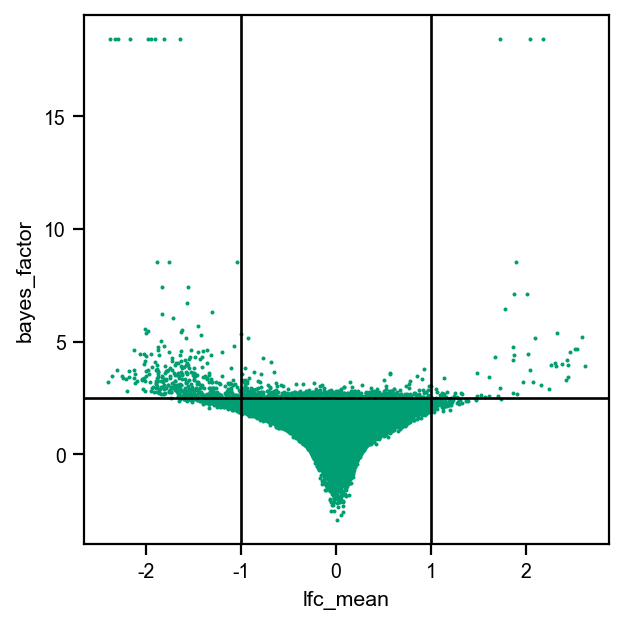

In [14]:
detected_genes_WT = {}
filtered_genes_WT = {}
for key, all_gene in all_genes_WT.items():
    print(key)
    if key == "Aire":
        color=cmap[1]
    else:
        color=cmap[2]
    adata = adatas[key]
    subset_data = adata[adata.obs.batch.str.contains(f"{key}_WT")]
    detected_gene, filtered_gene = filter_scvi_de_genes(
        adata=subset_data,
        cell_type_key="majority_voting",
        expression_layer="scVI_normalized",
        df=all_gene,
        bayes_thresh=2.5,
        lfc_thresh=1,
        nonzero_thresh=0.05,
        percentile=0.99,
        peak_expression_thresh=0.5,
        color=color,
    )
    detected_genes_WT[key] = detected_gene
    filtered_genes_WT[key] = filtered_gene

In [15]:
for key, filtered_gene in filtered_genes.items():
    WT_filtered = filtered_genes_WT[key.split("-")[0]]
    filtered_gene = filtered_gene[~filtered_gene.gene.isin(WT_filtered.gene)]

## KO DE

In [16]:
all_genes_KO = {}
for genotype in ["Aire", "Fezf2"]:
    adata = adatas[genotype]
    model = models[genotype]
    data = adata[adata.obs.genotype == f"{genotype}_KO"]
    print(f"{genotype}")
    all_gene = scvi_cell_type_de(
        adata=data,
        model=model,
        cell_type_key="majority_voting",
        group_key="sample",
        condition_group="1",
        control_group="2",
        min_cells=30,
    )
    all_genes_KO[genotype] = all_gene
    print()

Aire
Aire-stage
Gut/Liver
TA MEC
Immature MEC
Tuft2
Lung, basal
Neuroendocrine
Tuft1
Goblet
Mcell
Skin, basal
Skin, keratinized had too few cells in at least one group, skipping
Ciliated had too few cells in at least one group, skipping

Fezf2
Immature MEC
Aire-stage
TA MEC
Lung, basal
Goblet
Gut/Liver
Neuroendocrine had too few cells in at least one group, skipping
Skin, keratinized
Tuft2
Mcell
adult cTEC
Ciliated had too few cells in at least one group, skipping
Skin, basal
Tuft1 had too few cells in at least one group, skipping
Ionocyte had too few cells in at least one group, skipping



Aire


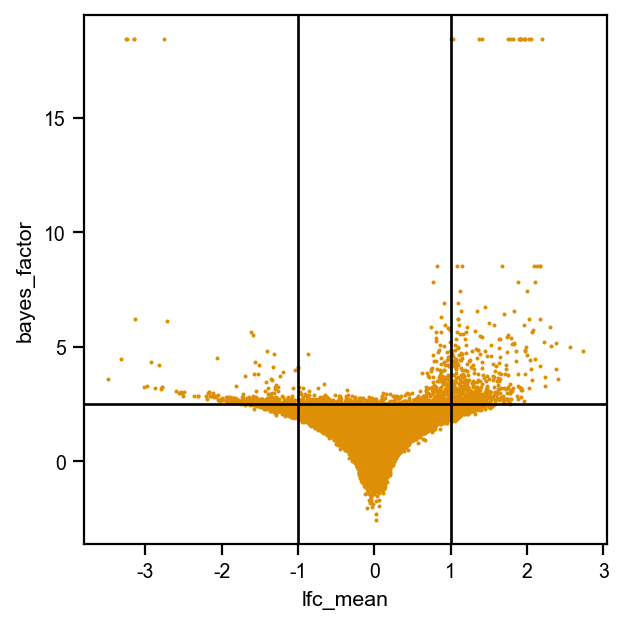

Fezf2


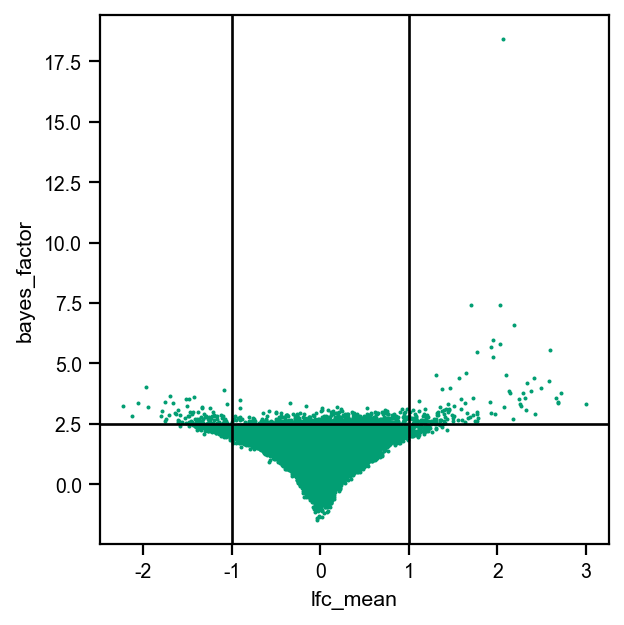

In [17]:
detected_genes_KO = {}
filtered_genes_KO = {}
for key, all_gene in all_genes_KO.items():
    print(key)
    if key == "Aire":
        color=cmap[1]
    else:
        color=cmap[2]
    adata = adatas[key]
    subset_data = adata[adata.obs.genotype == f"{key}_KO"]
    detected_gene, filtered_gene = filter_scvi_de_genes(
        adata=subset_data,
        cell_type_key="majority_voting",
        expression_layer="scVI_normalized",
        df=all_gene,
        bayes_thresh=2.5,
        lfc_thresh=1,
        nonzero_thresh=0.05,
        percentile=0.99,
        peak_expression_thresh=0.5,
        color=color,
    )
    detected_genes_KO[key] = detected_gene
    filtered_genes_KO[key] = filtered_gene

In [18]:
for key, filtered_gene  in filtered_genes.items():
    KO_filtered = filtered_genes_KO[key.split("-")[0]]
    filtered_gene = filtered_gene[~filtered_gene.gene.isin(KO_filtered.gene)]

## Sample reproducibility

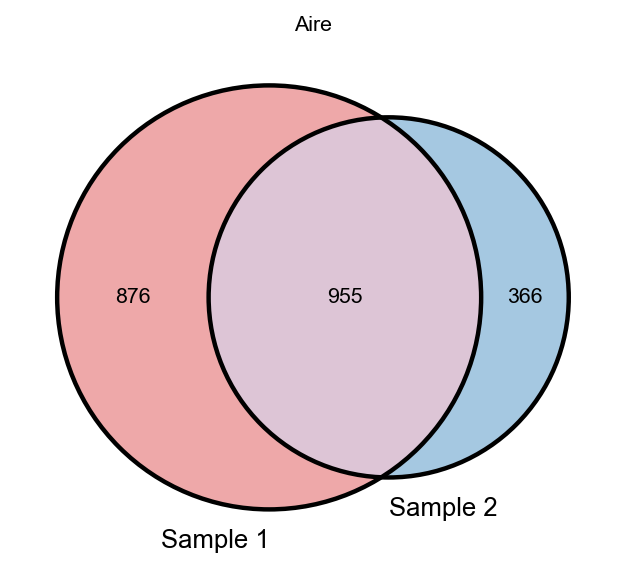

Aire % shared: 43.47


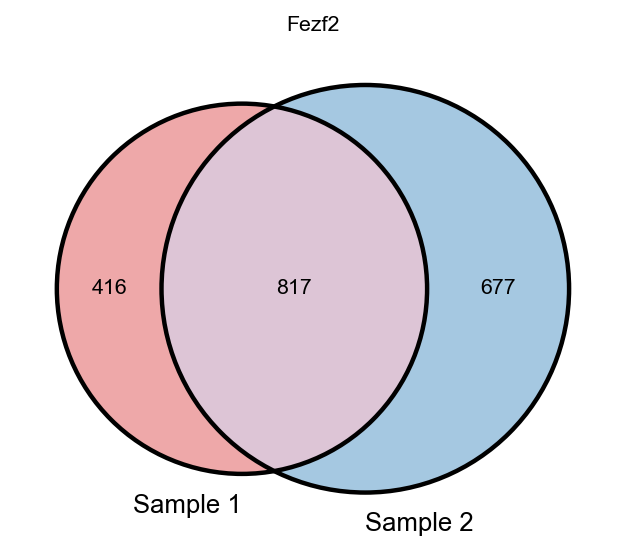

Fezf2 % shared: 42.77


In [19]:
for genotype in ["Aire", "Fezf2"]:
    sample_1 = filtered_genes[f"{genotype}-1"]
    sample_2 = filtered_genes[f"{genotype}-2"]

    both_genes = {i for i in sample_1.gene if i in sample_2.gene.tolist()}
    sample_1_genes = {i for i in sample_1.gene if i not in both_genes}
    sample_2_genes = {i for i in sample_2.gene if i not in both_genes}
    
    for sample in ["1", "2"]:
        filtered_genes[f"{genotype}-{sample}"].loc[
            filtered_genes[f"{genotype}-{sample}"].gene.isin(both_genes),
            "sample"
        ] = "both"
        filtered_genes[f"{genotype}-{sample}"].loc[
            filtered_genes[f"{genotype}-{sample}"].gene.isin(sample_1_genes),
            "sample"
        ] = "1"
        filtered_genes[f"{genotype}-{sample}"].loc[
            filtered_genes[f"{genotype}-{sample}"].gene.isin(sample_2_genes),
            "sample"
        ] = "2"
    
    venn2(
        subsets = (len(sample_1_genes), len(sample_2_genes), len(both_genes)), 
        set_labels = ('Sample 1', 'Sample 2'),
        set_colors = ["tab:red", "tab:blue"]
    )
    venn2_circles(subsets = (len(sample_1_genes), len(sample_2_genes), len(both_genes)))
    plt.title(genotype)
    plt.tight_layout()
    plt.show()
    print(f"{genotype} % shared: {round(len(both_genes)/(len(both_genes)+len(sample_1_genes)+len(sample_2_genes))*100, 2)}")

## Take intersection

In [20]:
for genotype in ["Aire", "Fezf2"]:
    sample_1 = filtered_genes[f"{genotype}-1"]
    sample_2 = filtered_genes[f"{genotype}-2"]
    sample_1 = sample_1[sample_1["sample"] == "both"]
    sample_1.index = sample_1.index + "_" + "1"
    sample_2 = sample_2[sample_2["sample"] == "both"]
    sample_2.index = sample_2.index + "_" + "2"
    merged_df = pd.concat([sample_1, sample_2])
    filtered_genes[genotype] = merged_df
    filtered_genes[f"{genotype}_max_LFC"] = merged_df.sort_values(by="abs_lfc").drop_duplicates(subset="gene")
    filtered_genes[f"{genotype}_max_LFC"].index = filtered_genes[f"{genotype}_max_LFC"].gene
    
for genotype in ["Aire", "Fezf2"]:
    sample_1 = detected_genes[f"{genotype}-1"]
    sample_2 = detected_genes[f"{genotype}-2"]
    sample_1 = sample_1[sample_1.index.isin(sample_2.index)]
    sample_1.index = sample_1.index + "_" + "1"
    sample_2 = sample_2[sample_2.index.isin(sample_1.index)]
    sample_2.index = sample_2.index + "_" + "2"
    merged_df = pd.concat([sample_1, sample_2])
    filtered_genes[genotype] = merged_df
    detected_genes[f"{genotype}_max_LFC"] = merged_df.sort_values(by="abs_lfc").drop_duplicates(subset="gene")
    detected_genes[f"{genotype}_max_LFC"].index = detected_genes[f"{genotype}_max_LFC"].gene

# Num regulated genes comparison

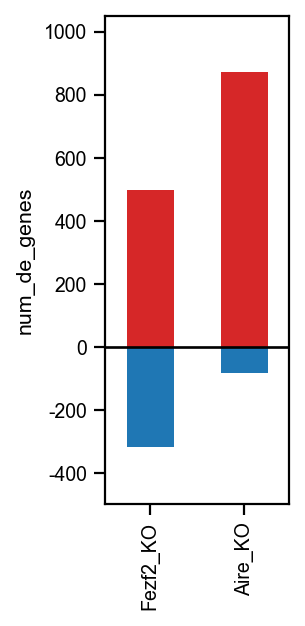

In [21]:
plotData = {}
plotData["up"] = [sum(filtered_genes["Fezf2_max_LFC"].lfc_mean > 0), sum(filtered_genes["Aire_max_LFC"].lfc_mean > 0)]
plotData["down"] = [sum(filtered_genes["Fezf2_max_LFC"].lfc_mean < 0), sum(filtered_genes["Aire_max_LFC"].lfc_mean < 0)]

plotData = pd.DataFrame(plotData, index=["Fezf2_KO", "Aire_KO"])

fig=plt.figure(figsize=(2,4))
plt.bar(x=plotData.index, height=plotData.down, color='tab:red', width=0.5)
plt.bar(x=plotData.index, height=-plotData.up, color='tab:blue', width=0.5)
plt.xticks([0,1], plotData.index, rotation='vertical')
plt.ylabel("num_de_genes")
plt.axhline(y=0, c="black")
plt.margins(0.15)
plt.tight_layout()
plt.savefig(f"../../analysis/paper_figures/S5/S5E_num_de_genes.pdf")
plt.show()

In [22]:
print(f"Aire up: {sum(filtered_genes['Aire_max_LFC'].lfc_mean < 0)}")
print(f"Aire down: {sum(filtered_genes['Aire_max_LFC'].lfc_mean > 0)}")
print(f"Fezf2 up: {sum(filtered_genes['Fezf2_max_LFC'].lfc_mean < 0)}")
print(f"Fezf2 down: {sum(filtered_genes['Fezf2_max_LFC'].lfc_mean > 0)}")

Aire up: 872
Aire down: 83
Fezf2 up: 499
Fezf2 down: 318


# DE comparison

In [23]:
with open('../../analysis/DE/filtered_genes.pkl', 'rb') as handle:
    all_de_genes = pickle.load(handle)

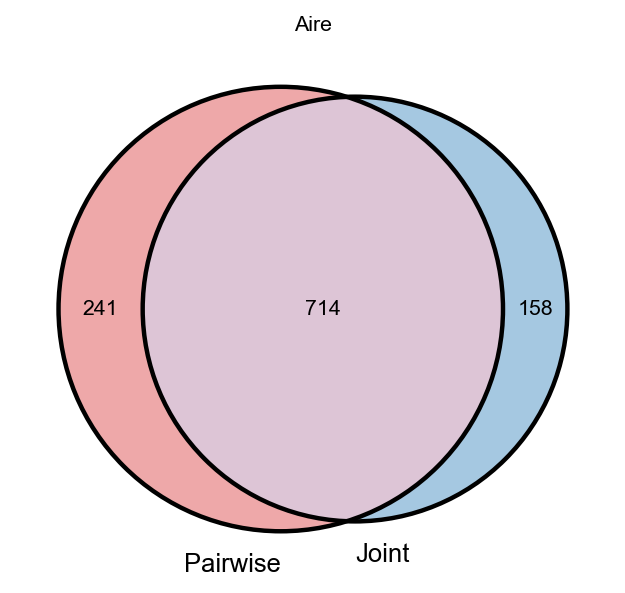

Aire % shared: 64.15


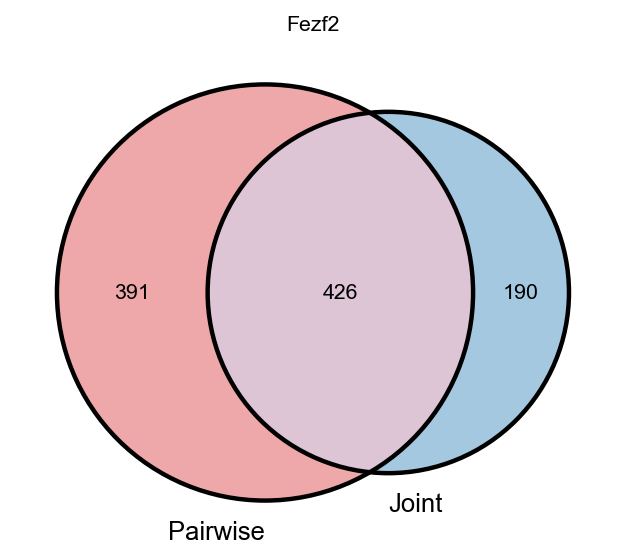

Fezf2 % shared: 42.3


In [24]:
for genotype in ["Aire", "Fezf2"]:
    de_genes = filtered_genes[f"{genotype}_max_LFC"]
    all_genes = all_de_genes[f"{genotype}_max_LFC"]
    
    both = de_genes[de_genes.index.isin(all_genes.index)]
    pairwise = de_genes[~de_genes.index.isin(all_genes.index)]
    joint = all_genes[~all_genes.index.isin(de_genes.index)]
    
    venn2(
        subsets = (len(pairwise), len(joint), len(both)),
        set_labels = ('Pairwise', 'Joint'),
        set_colors = ["tab:red", "tab:blue"]
    )
    venn2_circles(subsets = (len(pairwise), len(joint), len(both)),)
    plt.title(genotype)
    plt.tight_layout()
    plt.savefig(f"../../analysis/paper_figures/S5/S5D_{genotype}_de_gene_overlap.pdf")
    plt.show()
    print(f"{genotype} % shared: {round(len(both)/(len(both)+len(pairwise)+len(joint))*100, 2)}")

# Save dictionaries

In [25]:
with open('../../analysis/DE/pairwise_filtered_genes.pkl', 'wb') as handle:
    pickle.dump(filtered_genes, handle)
    
with open('../../analysis/DE/pairewise_detected_genes.pkl', 'wb') as handle:
    pickle.dump(detected_genes, handle)
    
with open('../../analysis/DE/pairewise_all_genes.pkl', 'wb') as handle:
    pickle.dump(all_genes, handle)